In [1]:
import sys
import os

from mpi4py import MPI

import numpy as np
import pyvista
import scipy.sparse

import dolfinx
import ufl

In [2]:
if sys.platform == "linux" and (os.getenv("CI") or pyvista.OFF_SCREEN):
    pyvista.start_xvfb(0.05)

In [3]:
def approximate_function(N: int, degree: int):
    mesh = dolfinx.mesh.create_unit_interval(MPI.COMM_WORLD, N)

    def g(x):
        return x[0] + np.sin(np.pi * x[0]) * np.cos(3 * np.pi * x[0])

    V = dolfinx.fem.functionspace(mesh, ("Lagrange", degree))
    u = dolfinx.fem.Function(V)
    u.interpolate(g)

    # Warp solution function and smoothen for higher order polynomial
    pv_grid = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(V))
    pv_grid.point_data["u"] = u.x.array
    warped = pv_grid.warp_by_scalar("u", normal=[0, 1, 0])
    warped_tessellate = warped.tessellate()

    # Compute reference solution
    x_ref = np.linspace(0, 1, 1000)
    g_ref = g(x_ref.reshape(1, -1))

    # warp grid nodes to match the solution
    lin_V = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))
    lin_u = dolfinx.fem.Function(lin_V)
    lin_u.interpolate(u)
    lin_grid = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(lin_V))
    lin_grid.point_data["u"] = lin_u.x.array
    lin_warped = lin_grid.warp_by_scalar("u", normal=[0, 1, 0])
    pyvista.set_jupyter_backend("static")
    plotter = pyvista.Plotter()
    plotter.add_lines(
        np.vstack([x_ref, g_ref, np.zeros_like(x_ref)]).T, connected=True, color="red", label="Exact", width=3
    )
    plotter.add_mesh(warped_tessellate, color="b", style="wireframe", label="Approximation", line_width=3)
    plotter.add_mesh(lin_warped, color="b", style="points", point_size=10)
    plotter.view_xy()
    plotter.add_legend(face="triangle")
    plotter.show()
    pyvista.set_jupyter_backend("html")




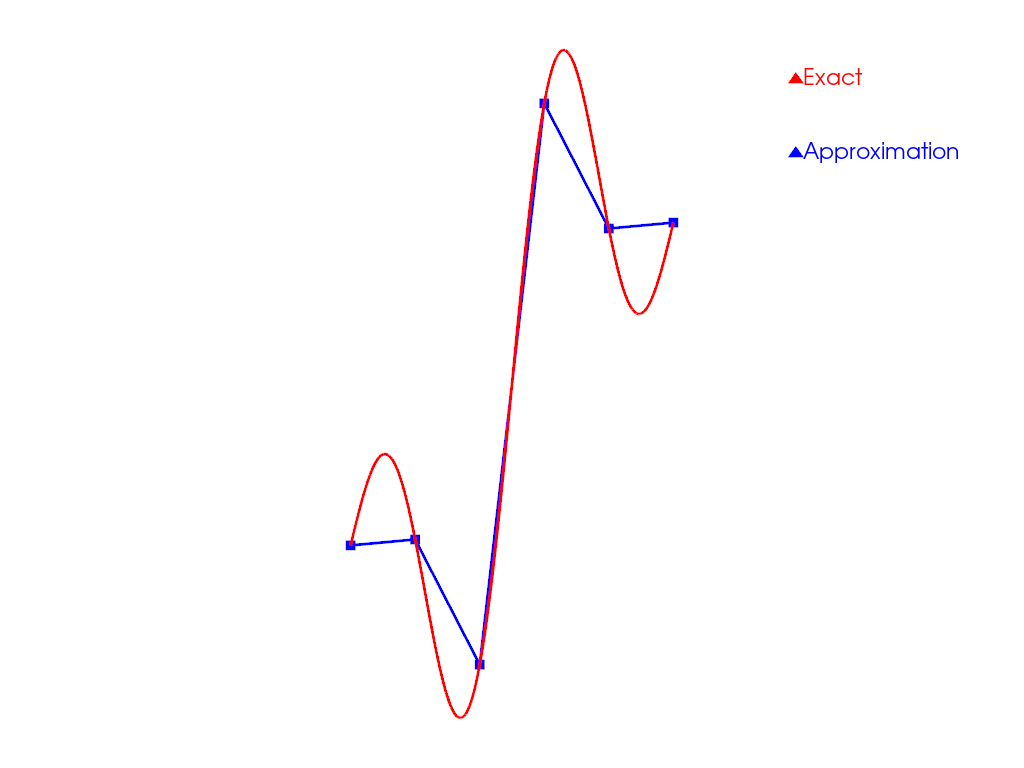

In [4]:
approximate_function(5, 1)

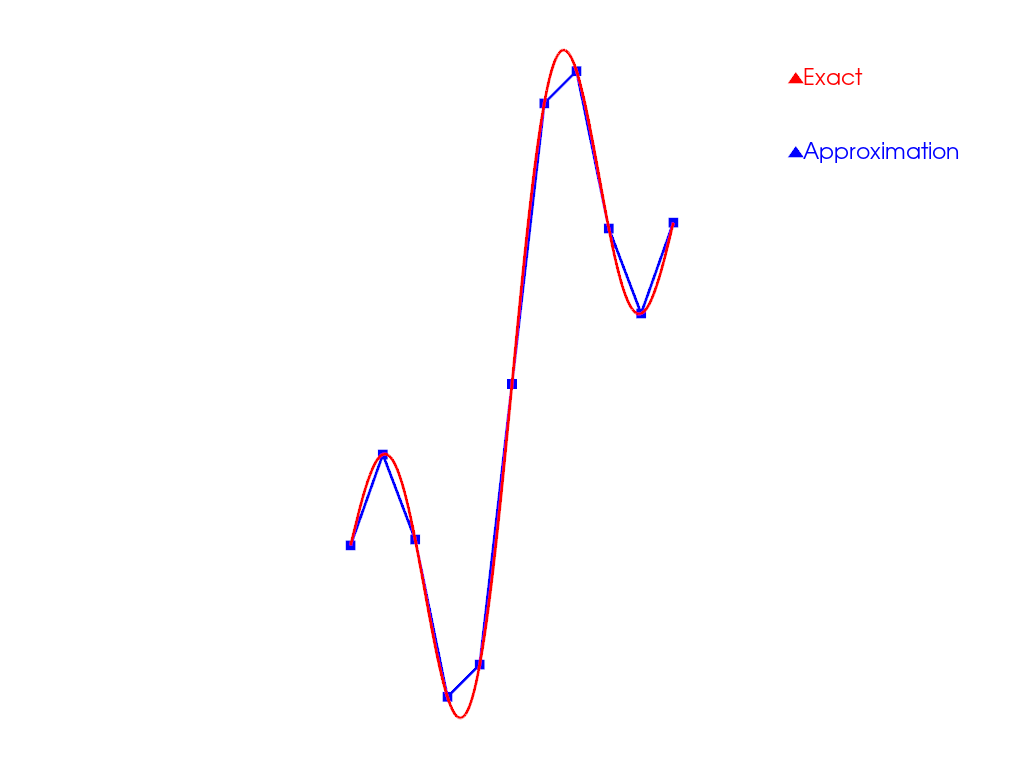

In [5]:
# We could then increase the number of elements used

# + tags=["hide-input"]
approximate_function(10, 1)